In [4]:
from dlab import sorting_quality as sq
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans2

import numpy as np
import seaborn as sns
import pandas as pd
import os, csv, time
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2 
sns.set_style("white")

In [5]:
directory = '/Volumes/DATA2/temporal/M310008/M310008_2017-04-13_07-35-06'
filename  = 'experiment1_102-0_0.dat'

## compute all metrics

In [ ]:
channels2 = 'all'#[0,384]
time_limits = None#[500.,600.]

t0 = time.time()
quality = sq.masked_cluster_quality(directory,time_limits)
print('PCA quality took '+str(time.time()-t0)+' sec');t0 = time.time()
isiV = sq.isiViolations(directory,time_limits)
print('ISI quality took '+str(time.time()-t0)+' sec');t0 = time.time();
SN = sq.cluster_signalToNoise(directory,time_limits,filename=filename)
print('SN quality took '+str(time.time()-t0)+' sec');t0 = time.time()

cluster_groups = sq.read_cluster_groups_CSV(directory)   

building features matrix from clusters / templates
computing cluster qualities...
number of clusters: 181
cluster 1: # spikes:32  iso. distance:7.48903109934141  contamination:0.0  1/181
cluster 4: # spikes:29133  iso. distance:4.483991312613925  contamination:0.3735283012391446  2/181
cluster 6: # spikes:88481  iso. distance:4.043191374282068  contamination:0.5370644545156587  3/181
cluster 8: # spikes:82235  iso. distance:5.955801288523079  contamination:0.07894448835653922  4/181
cluster 9: # spikes:59952  iso. distance:2.5070186342547434  contamination:0.9757639444889245  5/181
cluster 10: # spikes:15854  iso. distance:3.025081938898507  contamination:0.9456288633783272  6/181
cluster 11: # spikes:41033  iso. distance:3.169015608770224  contamination:0.8555796553993127  7/181
cluster 12: # spikes:1  iso. distance:0.0  contamination:nan  8/181
cluster 13: # spikes:11520  iso. distance:3.423873096318192  contamination:0.815625  9/181
cluster 14: # spikes:13102  iso. distance:5.267721

### put them all in a dataframe

In [184]:
cluster_group = []
color = []
for clu_id in isiV[0]:
    if clu_id in cluster_groups[0]:
        cluster_group.append('good')
        color.append(sns.color_palette()[1])
    else:
        if clu_id in cluster_groups[1]:
            cluster_group.append('mua')
            color.append(sns.color_palette()[0])
        else:
            if clu_id in cluster_groups[2]:
                cluster_group.append('unsorted')
                color.append(sns.color_palette()[1])
            else:
                cluster_group.append('noise')
                color.append(sns.color_palette()[1])

In [198]:
df = pd.DataFrame({
        'clusterID':isiV[0],
        'isi_violations':np.ones(len(isiV[1])) - isiV[1],
        'sn_max':SN[1],
        'sn_mean':SN[2],
        'isolation_distance':quality[1],
        'mahalanobis_contamination':np.ones(len(quality[2]))-quality[2],
        'FLDA_dprime':quality[3]*-1,
        'cluster_group':cluster_group,
        'color':color,
    })
df_sorted = df[df.cluster_group!='noise'][df.cluster_group!='unsorted']

/Users/administrator/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [211]:
#remove outliers
dft = df[df.sn_max <= 10.]
dft = dft[df.isolation_distance <= 100.]

/Users/administrator/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


## plot all metric scatters and distributions

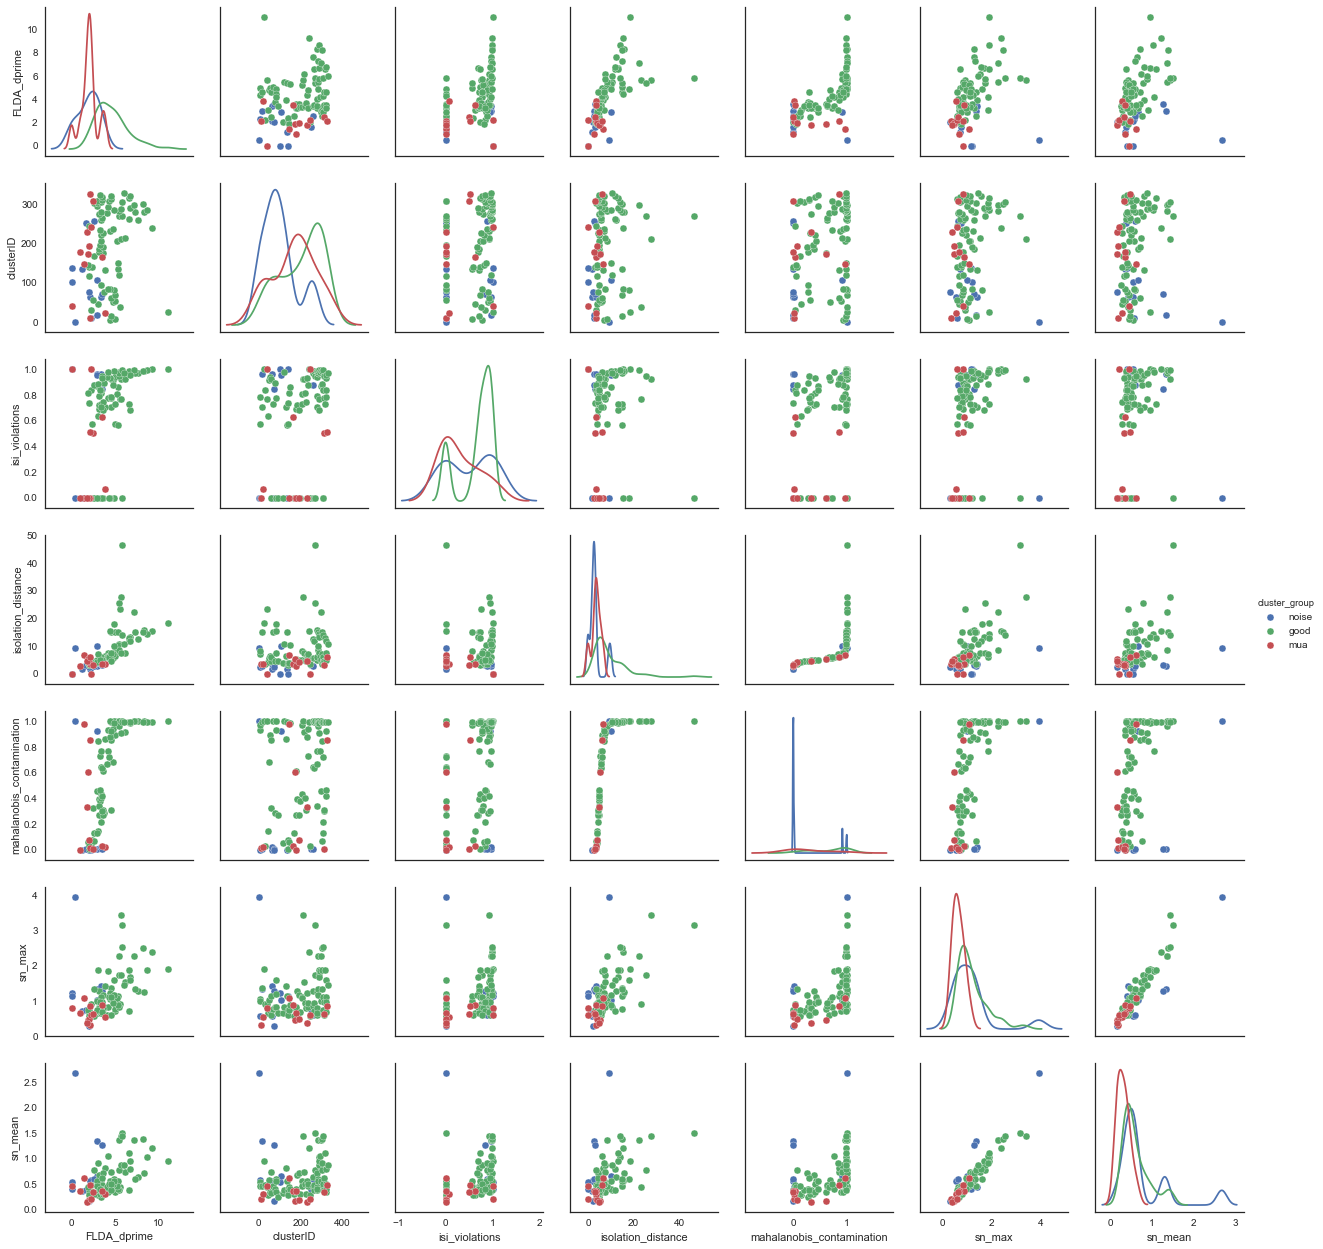

In [200]:
sns.pairplot(dft,
             diag_kind='kde',markers='o',hue='cluster_group')

### plot a 2D embedding with tSNE

In [213]:
metrics = dft.as_matrix(columns=['isi_violations',
                                    'sn_max',
                                    'sn_mean',
                                    'isolation_distance',
                                    'mahalanobis_contamination',
                                    'FLDA_dprime',
                                 ])
metrics = np.nan_to_num(metrics)

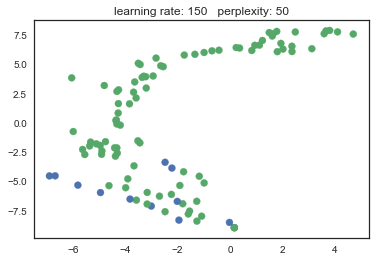

In [195]:
X_tsne = TSNE(learning_rate=80,perplexity=20).fit_transform(metrics)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=np.array(dft.color))
plt.gca().set_title('learning rate: '+str(150)+'   perplexity: '+str(50))

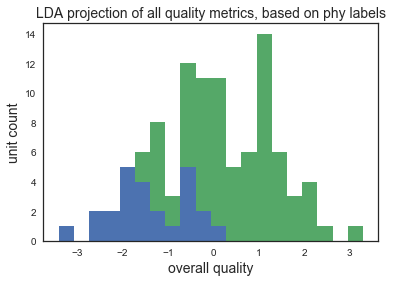

In [214]:
labels = np.zeros(np.shape(dft)[0])
labels[np.array(dft.cluster_group)=='good']=1
linear_quality = sq.project_linear_quality(metrics,labels)
d=plt.hist([linear_quality[labels==0],
          linear_quality[labels==1]],bins=20,stacked=True)
plt.xlabel('overall quality',size=14);plt.ylabel('unit count',size=14);plt.title('LDA projection of all quality metrics, based on phy labels',size=14)

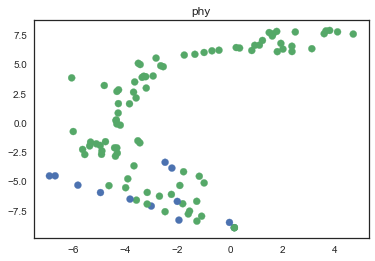

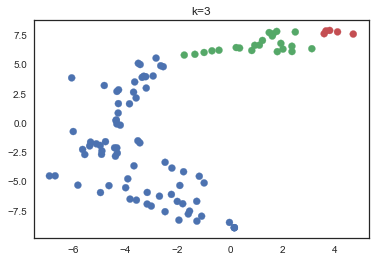

In [196]:
kn=3
km = kmeans2(metrics,
        kn, iter=300, thresh=5e-6,minit='random')
c2 = np.array([sns.color_palette()[k] for k in km[1]])
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=np.array(dft.color))
plt.gca().set_title('phy')
plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=c2)
plt.gca().set_title('k='+str(kn))

## plot individual unit summaries, showing data and metrics

no sampling rate specified, using default of 30kHz
['57', '82', '256']


ValueError: Cannot take a larger sample than population when 'replace=False'

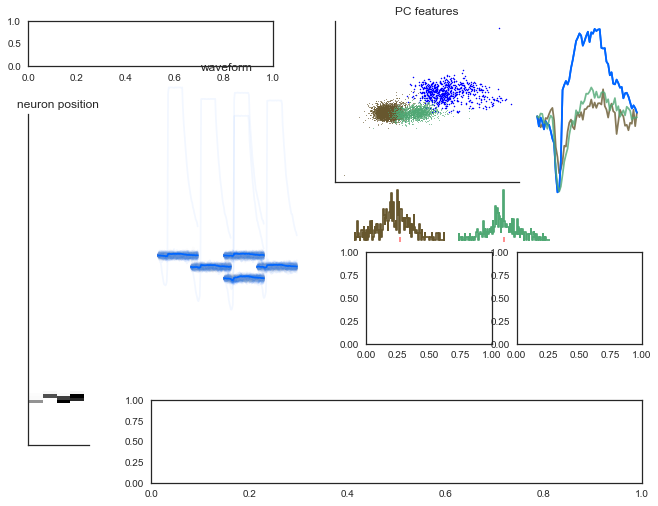

In [197]:
df_good = df[df.cluster_group=='good']
d=sq.neuron_fig(clusterID=str(df_good.clusterID[df.isolation_distance == df_good.isolation_distance.max()].values[0]),
                df=df,
                sortpath=directory,
               filename='experiment1_102-0_0.dat')